# Strata.ai - Artificial Intelligence Certificate 

# Module 1: Data Science for AI

# Dealing with BigData with Dask

# Dask DataFrames

Dask is a flexible library for parallel computing in Python.

Dask is composed of two parts:

* **Dynamic task scheduling optimized** for computation. This is similar to Airflow, Luigi, Celery, or Make, but optimized for interactive computational workloads.

* **“Big Data” collections** like parallel arrays, dataframes, and lists that extend common interfaces like NumPy, Pandas, or Python iterators to larger-than-memory or distributed environments. These parallel collections run on top of dynamic task schedulers.

Dask emphasizes the following virtues:

* **Familiar:** Provides parallelized NumPy array and Pandas DataFrame objects

* **Flexible:** Provides a task scheduling interface for more custom workloads and integration with other projects.

* **Native:** Enables distributed computing in pure Python with access to the PyData stack.

* **Fast:** Operates with low overhead, low latency, and minimal serialization necessary for fast numerical algorithms

* **Scales up:** Runs resiliently on clusters with 1000s of cores

* **Scales down:** Trivial to set up and run on a laptop in a single process

* **Responsive:** Designed with interactive computing in mind, it provides rapid feedback and diagnostics to aid humans

<img src="https://docs.dask.org/en/stable/_images/dask-overview.svg"/>

Reference: https://github.com/dask/dask-examples/blob/main/dataframe.ipynb

## Start Dask Client for Dashboard

Starting the Dask Client is optional.  It will provide a dashboard which 
is useful to gain insight on the computation.  

The link to the dashboard will become visible when you create the client below.  We recommend having it open on one side of your screen while using your notebook on the other side.  This can take some effort to arrange your windows, but seeing them both at the same is very useful when learning.

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

Client Scheduler: tcp://127.0.0.1:51305 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 1.86 GiB


## Create Random Dataframe

We create a random timeseries of data with the following attributes:

1.  It stores a record for every 10 seconds of the year 2000
2.  It splits that year by month, keeping every month as a separate Pandas dataframe
3.  Along with a datetime index it has columns for names, ids, and numeric values

This is a small dataset of about 240 MB. Increase the number of days or reduce the frequency to practice with a larger dataset.

In [2]:
import dask
import dask.dataframe as dd
df = dask.datasets.timeseries()

Unlike Pandas, Dask DataFrames are lazy and so no data is printed here.

In [3]:
df

,id,name,x,y
npartitions=30,,,,
2000-01-01,int64,object,float64,float64
2000-01-02,...,...,...,...
...,...,...,...,...
2000-01-30,...,...,...,...
2000-01-31,...,...,...,...


But the column names and dtypes are known.

In [4]:
df.dtypes

id        int64
name     object
x       float64
y       float64
dtype: object

Some operations will automatically display the data.

In [5]:
import pandas as pd
pd.options.display.precision = 2
pd.options.display.max_rows = 10

In [6]:
df.head(3)

,id,name,x,y
timestamp,,,,
2000-01-01 00:00:00,970,Michael,-0.23,0.19
2000-01-01 00:00:01,996,Ingrid,-0.16,-0.75
2000-01-01 00:00:02,995,Ursula,-0.73,0.34


## Use Standard Pandas Operations

Most common Pandas operations operate identically on Dask dataframes

In [7]:
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 157 tasks

Call `.compute()` when you want your result as a Pandas dataframe.

If you started `Client()` above then you may want to watch the status page during computation.

In [8]:
computed_df = df3.compute()
type(computed_df)

pandas.core.series.Series

In [9]:
computed_df

name
Alice      0.58
Bob        0.58
Charlie    0.58
Dan        0.58
Edith      0.58
           ... 
Victor     0.58
Wendy      0.58
Xavier     0.58
Yvonne     0.58
Zelda      0.58
Name: x, Length: 26, dtype: float64

## Persist data in memory

If you have the available RAM for your dataset then you can persist data in memory.  

This allows future computations to be much faster.

In [10]:
df = df.persist()

## Time Series Operations

Because we have a datetime index time-series operations work efficiently

In [11]:
%matplotlib inline

In [12]:
df[['x', 'y']].resample('1h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,1.69e-02,1.18e-02
2000-01-01 01:00:00,-9.57e-03,-1.83e-02
2000-01-01 02:00:00,6.19e-04,5.76e-03
2000-01-01 03:00:00,1.83e-03,1.01e-02
2000-01-01 04:00:00,-1.12e-02,-1.08e-03


<AxesSubplot:xlabel='timestamp'>

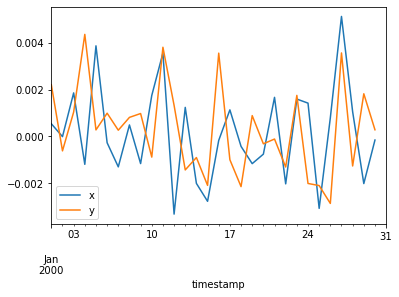

In [13]:
df[['x', 'y']].resample('24h').mean().compute().plot()

In [14]:
df[['x', 'y']].rolling(window='24h').mean().head()

,x,y
timestamp,,
2000-01-01 00:00:00,-0.23,0.19
2000-01-01 00:00:01,-0.19,-0.28
2000-01-01 00:00:02,-0.37,-0.07
2000-01-01 00:00:03,-0.05,0.14
2000-01-01 00:00:04,0.15,0.19


Random access is cheap along the index, but must still be computed.

In [15]:
df.loc['2000-01-05']

,id,name,x,y
npartitions=1,,,,
2000-01-05 00:00:00.000000000,int64,object,float64,float64
2000-01-05 23:59:59.999999999,...,...,...,...


In [16]:
%time df.loc['2000-01-05'].compute()

CPU times: user 20.8 ms, sys: 9.47 ms, total: 30.3 ms
Wall time: 40 ms


,id,name,x,y
timestamp,,,,
2000-01-05 00:00:00,987,Hannah,-0.07,-1.96e-01
2000-01-05 00:00:01,993,Ursula,-0.09,3.17e-02
2000-01-05 00:00:02,1011,Ingrid,0.79,4.30e-01
2000-01-05 00:00:03,1010,Michael,-0.93,2.19e-01
2000-01-05 00:00:04,960,Zelda,0.63,-1.08e-02
...,...,...,...,...
2000-01-05 23:59:55,1003,Frank,-0.30,-4.92e-01
2000-01-05 23:59:56,958,Norbert,0.53,8.06e-01
2000-01-05 23:59:57,1002,Sarah,-0.43,5.18e-01


## Set Index

Data is sorted by the index column.  This allows for faster access, joins, groupby-apply operations, etc..  However sorting data can be costly to do in parallel, so setting the index is both important to do, but only infrequently.

In [17]:
df = df.set_index('name')
df

,id,x,y
npartitions=30,,,
Alice,int64,float64,float64
Alice,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


Because computing this dataset is expensive and we can fit it in our available RAM, we persist the dataset to memory.

In [18]:
df = df.persist()

Dask now knows where all data lives, indexed cleanly by name.  As a result oerations like random access are cheap and efficient

In [19]:
%time df.loc['Alice'].compute()

CPU times: user 26.3 ms, sys: 9.67 ms, total: 35.9 ms
Wall time: 66.1 ms


,id,x,y
name,,,
Alice,967,8.68e-01,-0.39
Alice,998,6.18e-01,0.08
Alice,980,-2.51e-01,-0.59
Alice,1023,4.20e-01,0.61
Alice,1023,-2.43e-01,-0.94
...,...,...,...
Alice,967,-8.44e-01,0.15
Alice,985,-1.54e-01,0.56
Alice,1008,9.14e-01,-0.83
